In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid

In [2]:
train_set = pd.read_csv("/kaggle/input/digit-recognizer/train.csv", sep=",")

In [3]:
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv", sep=",")

In [4]:
train_labels = train_set['label'].values

In [5]:
train_images = (train_set.iloc[:,1:].values).astype('float32')

In [6]:
test_images = (test_df.iloc[:,:].values).astype('float32')

In [7]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

In [9]:
train_images_tensor = torch.tensor(train_images) / 255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

In [10]:
val_images_tensor = torch.tensor(val_images) / 255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

In [11]:
test_images_tensor = torch.tensor(test_images) / 255.0

In [12]:
train_loader = DataLoader(train_tensor, batch_size=16, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, shuffle=False)

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


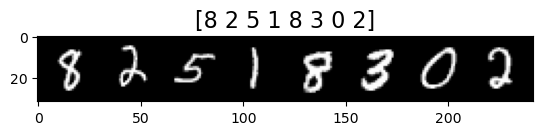

In [13]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1))
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.title(img_target_labels, size=16)
plt.show()

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        
        self.linear = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(401408, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
    
    def forward(self, image):
        conv = self.conv_layer(image)
        flatten = self.flatten(conv)
        result = self.linear(flatten)
        return result

In [15]:
classifier = Classifier()

In [16]:
n_epochs = 5

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
if torch.cuda.is_available():
    criterion.cuda()
    classifier.cuda()

In [21]:
for epoch in range(n_epochs):
    for batch_idx, (image_batch, labels_batch) in enumerate(tqdm(train_loader)):
        classifier.train()
        image_batch = image_batch.unsqueeze(1).to(device)
        
        
        outputs = classifier(image_batch)
        loss = criterion(outputs, labels_batch.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch_idx + 1)% 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))

 48%|████▊     | 1004/2100 [00:36<00:38, 28.63it/s]

Train Epoch: 0 [16000/33600 (48%)]	Loss: 0.836813


 95%|█████████▌| 2004/2100 [01:11<00:03, 28.92it/s]

Train Epoch: 0 [32000/33600 (95%)]	Loss: 0.059335


 48%|████▊     | 1004/2100 [00:35<00:38, 28.62it/s]

Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.027349


 95%|█████████▌| 2004/2100 [01:09<00:03, 28.94it/s]

Train Epoch: 1 [32000/33600 (95%)]	Loss: 0.020743


 48%|████▊     | 1004/2100 [00:35<00:38, 28.58it/s]

Train Epoch: 2 [16000/33600 (48%)]	Loss: 0.125665


 95%|█████████▌| 2004/2100 [01:09<00:03, 28.99it/s]

Train Epoch: 2 [32000/33600 (95%)]	Loss: 0.096302


 48%|████▊     | 1004/2100 [00:35<00:38, 28.57it/s]

Train Epoch: 3 [16000/33600 (48%)]	Loss: 0.131184


 95%|█████████▌| 2004/2100 [01:09<00:03, 28.99it/s]

Train Epoch: 3 [32000/33600 (95%)]	Loss: 0.007603


 48%|████▊     | 1004/2100 [00:35<00:38, 28.64it/s]

Train Epoch: 4 [16000/33600 (48%)]	Loss: 0.204758


 95%|█████████▌| 2004/2100 [01:09<00:03, 28.64it/s]

Train Epoch: 4 [32000/33600 (95%)]	Loss: 0.167884


100%|██████████| 2100/2100 [01:13<00:00, 28.67it/s]


In [22]:
classifier.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for image_batch, labels_batch in val_loader:
        image_batch = image_batch.unsqueeze(1).to(device)
        labels_batch = labels_batch.to(device)
        outputs = classifier(image_batch)
        something, predicted = torch.max(outputs, dim=1)
        
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()
    accuracy = correct / total

In [23]:
accuracy

0.9880952380952381

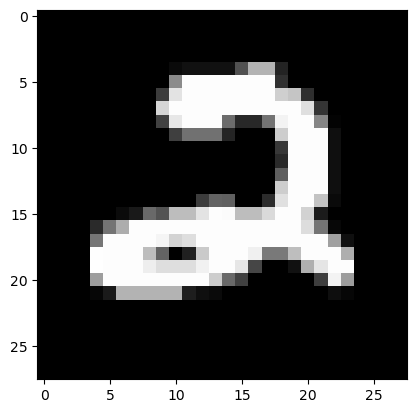

In [24]:
plt.imshow(test_images[0], cmap="gray")
plt.show()

In [25]:
image_to_predict = test_images[0]

In [26]:
image_to_predict = image_to_predict / 255.0

In [27]:
image_to_predict = torch.Tensor(image_to_predict)

In [28]:
image_to_predict.shape

torch.Size([28, 28])

In [29]:
image_to_predict = image_to_predict.unsqueeze(0).unsqueeze(1)

In [30]:
image_to_predict.shape

torch.Size([1, 1, 28, 28])

In [31]:
result = torch.argmax(classifier(image_to_predict.to(device)), dim=1)

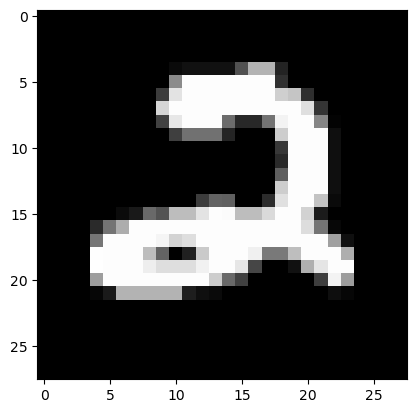

In [32]:
plt.imshow(image_to_predict.squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()

In [34]:
result.cpu().numpy()

array([2])